# Zero-shot Denoising via Neural Compression (ZS-NCD)

## 1. Installing required packages

Run cells either in Section 1.1 or 1.2 depending on your machine. (Cuda-enabled device is recommended)

### 1.1 MacOS
(Verified on MacOS 15.5 with M2 and M4 chips) To use Apple Silicon gpu training:

In [1]:
!pip install numpy matplotlib scikit-image torch torchvision pytorch-lightning compressai tensorboard --quiet

In [ ]:
import torch
print(torch.backends.mps.is_available())  # Should return True on Macs with apple silicon chip

### 1.2 Linux-based OS
(Verified on Ubuntu 22.04 with Nvidia A6000 ada) To use cuda-enabled training. Replace *cu124* with your installed CUDA version, e.g., *cu121*

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124 --quiet

In [ ]:
!pip install numpy matplotlib scikit-image  pytorch-lightning compressai tensorboard --quiet

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True

## 2. Definitions

In [ ]:
import os
import math
import time
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything, Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

from compressai.layers import GDN
from compressai.models.utils import conv, deconv
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.optimizers import net_aux_optimizer


def add_noise_and_save(image_path, noise_type, noise_parameter):
    img_np = np.array(Image.open(image_path)).astype(np.float32) / 255.0
    RGB = True if len(img_np.shape) > 2 else False

    if noise_type == 'gaussian':
        noise = np.random.normal(0, noise_parameter / 255.0, img_np.shape).astype(np.float32)
        noisy_np = img_np + noise
    elif noise_type == 'poisson':
        noisy_np = np.random.poisson(img_np * noise_parameter).astype(np.float32) / noise_parameter
    else:
        raise ValueError('noise type should be either "gaussian" or "poisson". ')

    psnr_val = psnr(img_np.clip(0, 1), noisy_np, data_range=1.0)
    ssim_val = ssim(img_np.clip(0, 1), noisy_np, data_range=1.0, channel_axis=2 if RGB else None)

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    out_dir = os.path.join(".", f'{base_name}_{noise_type}_{noise_parameter}')
    os.makedirs(out_dir, exist_ok=True)

    filename = f"{base_name}_{noise_type}_{noise_parameter}__psnr_{psnr_val:.2f}__ssim_{ssim_val:.4f}.npz"
    save_path = os.path.join(out_dir, filename)
    if RGB:
        img_np, noisy_np = img_np.transpose(2, 0, 1), noisy_np.transpose(2, 0, 1)
    else:
        img_np, noisy_np = img_np[None, :, :], noisy_np[None, :, :]
    np.savez(save_path, gt=img_np, noisy=noisy_np)
    return save_path, 3 if RGB else 1, out_dir


class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, patch_size):
        self.patch_size = patch_size
        # img_tensor = TVF.to_tensor(Image.open(image_path))
        noisy_img = torch.from_numpy(np.load(data_path)['noisy'])
        self.C, self.H, self.W = noisy_img.shape
        self.patches = F.unfold(noisy_img, kernel_size=patch_size, stride=1).permute(1, 0)

    def __len__(self):
        return self.patches.shape[0]

    def __getitem__(self, idx):
        flat_patch = self.patches[idx]
        return flat_patch.view(-1, self.patch_size, self.patch_size)


class PatchDataModule(LightningDataModule):
    def __init__(self, path, patch_size, batch_size, num_workers, persistent_workers=False):
        super().__init__()
        self.path = path
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers

    def setup(self, stage):
        self.patch_train = PatchDataset(self.path, self.patch_size)

    def train_dataloader(self):
        return DataLoader(self.patch_train,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          persistent_workers=self.persistent_workers,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader([[1],])  # empty placeholder to force validation step to run


class NC(CompressionModel):
    def __init__(self, n1, n2, nb, img_channels, k, network_type='Conv', use_gdn=True, **kwargs):
        super().__init__(**kwargs)
        self.entropy_bottleneck = EntropyBottleneck(nb)
        if network_type == 'Conv':
            self.g_a = nn.Sequential(
                conv(img_channels, n1, kernel_size=3, stride=2), GDN(n1) if use_gdn else nn.ReLU(inplace=True),
                conv(n1, n2, kernel_size=3, stride=2), GDN(n2) if use_gdn else nn.ReLU(inplace=True),
                conv(n2, nb, kernel_size=3, stride=2)
            )
            self.g_s = nn.Sequential(
                deconv(nb, n2, kernel_size=3, stride=2), GDN(n2) if use_gdn else nn.ReLU(inplace=True),
                deconv(n2, n1, kernel_size=3, stride=2), GDN(n1) if use_gdn else nn.ReLU(inplace=True),
                deconv(n1, img_channels, kernel_size=3, stride=2)
            )
        elif network_type == 'MLP':
            self.g_a = nn.Sequential(
                nn.Flatten(),
                nn.Linear(img_channels * k * k, n1), nn.ReLU(inplace=True),
                nn.Linear(n1, n2), nn.ReLU(inplace=True),
                nn.Linear(n2, nb)
            )

            self.g_s = nn.Sequential(
                nn.Linear(nb, n2), nn.ReLU(inplace=True),
                nn.Linear(n2, n1), nn.ReLU(inplace=True),
                nn.Linear(n1, img_channels * k * k),
                nn.Unflatten(1, (img_channels, k, k))
            )

    def forward(self, x):
        y = self.g_a(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.g_s(y_hat)
        return {"x_hat": x_hat, "likelihoods": {"y": y_likelihoods}}


class RateDistortionLoss(nn.Module):
    def __init__(self, lmbda, metric="mse", return_type="all"):
        super().__init__()
        if metric == "mse":
            self.metric = nn.MSELoss()
        else:
            raise NotImplementedError(f"{metric} is not implemented!")
        self.lmbda = lmbda
        self.return_type = return_type

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )

        out["mse_loss"] = self.metric(output["x_hat"], target)
        distortion = (255**2) * out["mse_loss"]

        out["loss"] = distortion + self.lmbda * out["bpp_loss"]

        if self.return_type == "all":
            return out
        else:
            return out[self.return_type]


class ZSNCD(LightningModule):
    def __init__(self,
                 data_path,
                 img_channels,
                 lmbda,
                 patch_size,
                 network_type='Conv',
                 net_lr=5e-3,
                 aux_lr=1e-4,
                 gradient_clip_norm=2.0):
        super(ZSNCD, self).__init__()

        n1 = 128 if network_type == 'Conv' else 1024
        n2 = n1
        nb = 32 if img_channels == 3 else 16
        self.net = NC(n1, n2, nb, img_channels, patch_size, network_type)

        self.patch_size = k

        self.data_path = data_path

        self.net_lr = net_lr
        self.aux_lr = aux_lr
        self.save_hyperparameters()

        self.gradient_clip_norm = gradient_clip_norm

        self.criterion = RateDistortionLoss(lmbda)
        self.automatic_optimization = False

    def forward(self, p):
        return self.net(p)

    def training_step(self, batch, batch_idx):
        net_opt, aux_opt = self.optimizers()
        net_opt.zero_grad()
        aux_opt.zero_grad()

        out_net = self(batch)

        out_criterion = self.criterion(out_net, batch)
        self.manual_backward(out_criterion["loss"])

        if self.gradient_clip_norm > 0.0:
            nn.utils.clip_grad_norm_(self.parameters(), self.gradient_clip_norm)

        net_opt.step()
        sch = self.lr_schedulers()

        sch.step()

        log_info = {
            "train/loss": out_criterion["loss"].item(),
            "train/mse": out_criterion["mse_loss"].item(),
            "train/bpp": out_criterion["bpp_loss"].item(),
            "train/psnr": -10 * math.log10(out_criterion["mse_loss"].item())
        }
        self.log_dict(log_info)

    def configure_optimizers(self):
        conf = {
            "net": {"type": "Adam", "lr": self.net_lr},
            "aux": {"type": "Adam", "lr": self.aux_lr},
        }
        optimizers = net_aux_optimizer(self, conf)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizers["net"], step_size=int(0.8*self.trainer.max_steps), gamma=0.1)

        return [{"optimizer": optimizers["net"], "lr_scheduler":scheduler},
                {"optimizer": optimizers["aux"]},]

    def denoise_patch(self, patch):
        y = self.net.g_a(patch)
        y_hat, y_likelihoods = self.net.entropy_bottleneck(y, training=False)
        patch_hat = self.net.g_s(y_hat)
        bpp = sum( (torch.log(likelihoods).sum() / (-math.log(2) * self.patch_size ** 2)) for likelihoods in {"y": y_likelihoods}.values())
        return patch_hat, bpp

    def denoise(self):
        gt_img = torch.from_numpy(np.load(self.data_path)['gt']).unsqueeze(dim=0).to(self.device)
        noisy_img = torch.from_numpy(np.load(self.data_path)['noisy']).unsqueeze(dim=0).to(self.device)

        _, c, h, w = gt_img.shape
        unfold = nn.Unfold(kernel_size=self.patch_size, stride=1)
        fold = nn.Fold(output_size=(h, w), kernel_size=self.patch_size, stride=1)

        noisy_patches = unfold(noisy_img)  # (1, c*k*k, N)
        noisy_patches = noisy_patches.permute(0, 2, 1)  # (1, N, c*k*k)
        noisy_patches = noisy_patches.view(-1, c, k, k)  # (N, 1, k, k)

        patch_hats, entropies = self.denoise_patch(noisy_patches)

        patch_hats_flat = patch_hats.view(1, -1, c * k * k)  # (1, N, c*k*k)
        patch_hats_flat = patch_hats_flat.permute(0, 2, 1)  # (1, c*k*k, N)
        denoised_img = fold(patch_hats_flat)

        ones = torch.ones_like(noisy_img)
        norm_map = fold(unfold(ones))
        denoised_img /= norm_map
        rate = entropies.sum() / norm_map.sum()

        denoised_mse = F.mse_loss(gt_img, denoised_img.clamp(0, 1))
        denoised_psnr = 10 * torch.log10(1 / denoised_mse)
        denoised_ssim = ssim(gt_img.cpu().numpy().squeeze(), denoised_img.clamp(0, 1).cpu().numpy().squeeze(), channel_axis=0 if c>1 else None, data_range=1.0)

        return denoised_mse, denoised_psnr, rate, denoised_img, denoised_ssim

    def validation_step(self, batch, batch_idx):
        denoised_mse, denoised_psnr, rate, denoised_img , denoised_ssim= self.denoise()
        self.log_dict({
            'valid/denoise-mse': denoised_mse,
            'valid/denoise-psnr': denoised_psnr,
            'valid/denoise-rate': rate.mean(),
            'valid/denoise-ssim': denoised_ssim
        })
        self.denoised_img = denoised_img


class TimeLogger(Callback):
    def on_train_start(self, trainer, pl_module):
        self.start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        elapsed = int(time.time() - self.start_time)
        pl_module.log("wall_time (min)", elapsed // 60, prog_bar=True, logger=True)


def image_saving_fn(pl_module):
    image = pl_module.denoised_img
    epoch = pl_module.current_epoch
    name = f"epoch_{epoch:03d}.png"
    return image, name


class ImageSavingModelCheckpoint(ModelCheckpoint):
    def __init__(self, image_saving_fn, image_dir, **kwargs):
        super().__init__(**kwargs)
        self.image_saving_fn = image_saving_fn
        self.image_dir = image_dir
        self.last_image_path = None
        os.makedirs(image_dir, exist_ok=True)

    # def _remove_old_images(self):
    #     files = sorted(os.listdir(self.image_dir))
    #     while len(files) > self.save_top_k:
    #         oldest = files[0]
    #         os.remove(os.path.join(self.image_dir, oldest))
    #         files = sorted(os.listdir(self.image_dir))

    def on_validation_end(self, trainer, pl_module):
        super().on_validation_end(trainer, pl_module)

        current_ckpt = self.best_k_models.keys()
        if len(current_ckpt) > 0:
            image_tensor, image_name = self.image_saving_fn(pl_module)
            image_path = os.path.join(self.image_dir, image_name)
            RGB = True if image_tensor.shape[1] == 3 else False
            image_tensor = image_tensor.squeeze().cpu().numpy().clip(0, 1)
            if RGB:
                image_tensor = image_tensor.transpose(1, 2, 0)
            Image.fromarray((image_tensor * 255).astype('uint8'), mode='RGB' if RGB else 'L').save(image_path)
            self.last_image_path = image_path
            # self._remove_old_images()


def get_device():
    if torch.cuda.is_available():
        device = 'gpu'
        device_id = [0, ]
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = 'mps'
        device_id = [0, ]
    else:
        device = 'cpu'
        device_id = [0, ]
    return device, device_id


def compare_and_plot(img1, img2, img1_title='Image 1', img2_title='Image 2'):
    psnr_val = psnr(img1, img2, data_range=1.0)
    ssim_val = ssim(img1, img2, data_range=1.0, channel_axis=2 if img1.ndim == 3 else None)
    
    plt.figure(figsize=(12, 8), dpi=500)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title(f'{img1_title}')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title(f'{img2_title} ({psnr_val:.2f} / {ssim_val:.4f})')

    plt.tight_layout()
    plt.show()

## 3. Logs (optional)

To track the progress of zero-shot denoising, you can open Tensorboard in the following cell.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./ --port 8764 --host localhost

## 4. Zero-shot denoising with ZS-NCD

Noise settings:

In [5]:
noise_type = 'gaussian'    # 'gaussian' or 'poisson'
noise_parameter = 25       # 'sigma' or 'alpha'

Path to the test image:

In [ ]:
# gt_image_path, lmbda = 'test_images/kodim05.png', 150        # 512x768 pixels
gt_image_path, lmbda = 'test_images/face.png', 250           # 192x192 pixels

Configurations:

In [16]:
k = 8  # patch size, i.e., (k, k)
batch_size = int(2**14)  # in case of gpu memory error decrease this, and increase num_steps proportionally
network_type = 'Conv'  # 'Conv' or 'MLP'
num_steps = int(2E3)  # paper uses 20k steps; 2k gives comparable results.
device, device_id = get_device()
dataloader_num_workers = 32 if device == 'gpu' else 0
dataloader_persistent_workers = True if dataloader_num_workers > 0 else False
validation_period = 1  # in number of epochs
logging_period = 1  # in number of steps
seed_everything(14)
print(f'device: {device} is available.')

Seed set to 14


device: mps is available.


Defining dataset (including a single image):

In [17]:
data_path, img_channels, results_directory = add_noise_and_save(gt_image_path, noise_type, noise_parameter)
data_module = PatchDataModule(data_path, k, batch_size, dataloader_num_workers)

Instantiating the ZS-NCD module:

In [ ]:
zsncd_module = ZSNCD(data_path, img_channels, lmbda, k, network_type)

tb_logger = TensorBoardLogger(save_dir=os.path.join(results_directory, 'log'), name='')
csv_logger = CSVLogger(save_dir=os.path.join(results_directory, 'log'), name='', version=tb_logger.version)

lastk_checkpoint = ImageSavingModelCheckpoint(
    monitor='epoch',
    mode='max',
    save_top_k=3,
    every_n_epochs=1,
    filename='last3__epoch_{epoch}__loss_{train/loss:.4f}__psnr_{valid/denoise-psnr:.2f}__ssim_{valid/denoise-ssim:.4f}',
    auto_insert_metric_name=False,
    save_on_train_epoch_end=False,
    verbose=False,
    image_saving_fn=image_saving_fn,
    image_dir=os.path.join(results_directory, 'log', f'version_{tb_logger.version:d}', 'denoised_images')
)

trainer = Trainer(
    default_root_dir=results_directory,
    accelerator=device,
    devices=device_id,
    max_steps=num_steps,
    check_val_every_n_epoch=validation_period,
    log_every_n_steps=logging_period,
    callbacks=[TimeLogger(),
               lastk_checkpoint],
    logger=[
        tb_logger,
        csv_logger
    ],
    num_sanity_val_steps=1
)
trainer.logger._default_hp_metric = None

Starting zero-shot denoising. You can stop it anytime and check the results by running the cells in Section 5.

In [ ]:
trainer.fit(model=zsncd_module, datamodule=data_module)

## 5. Visualization

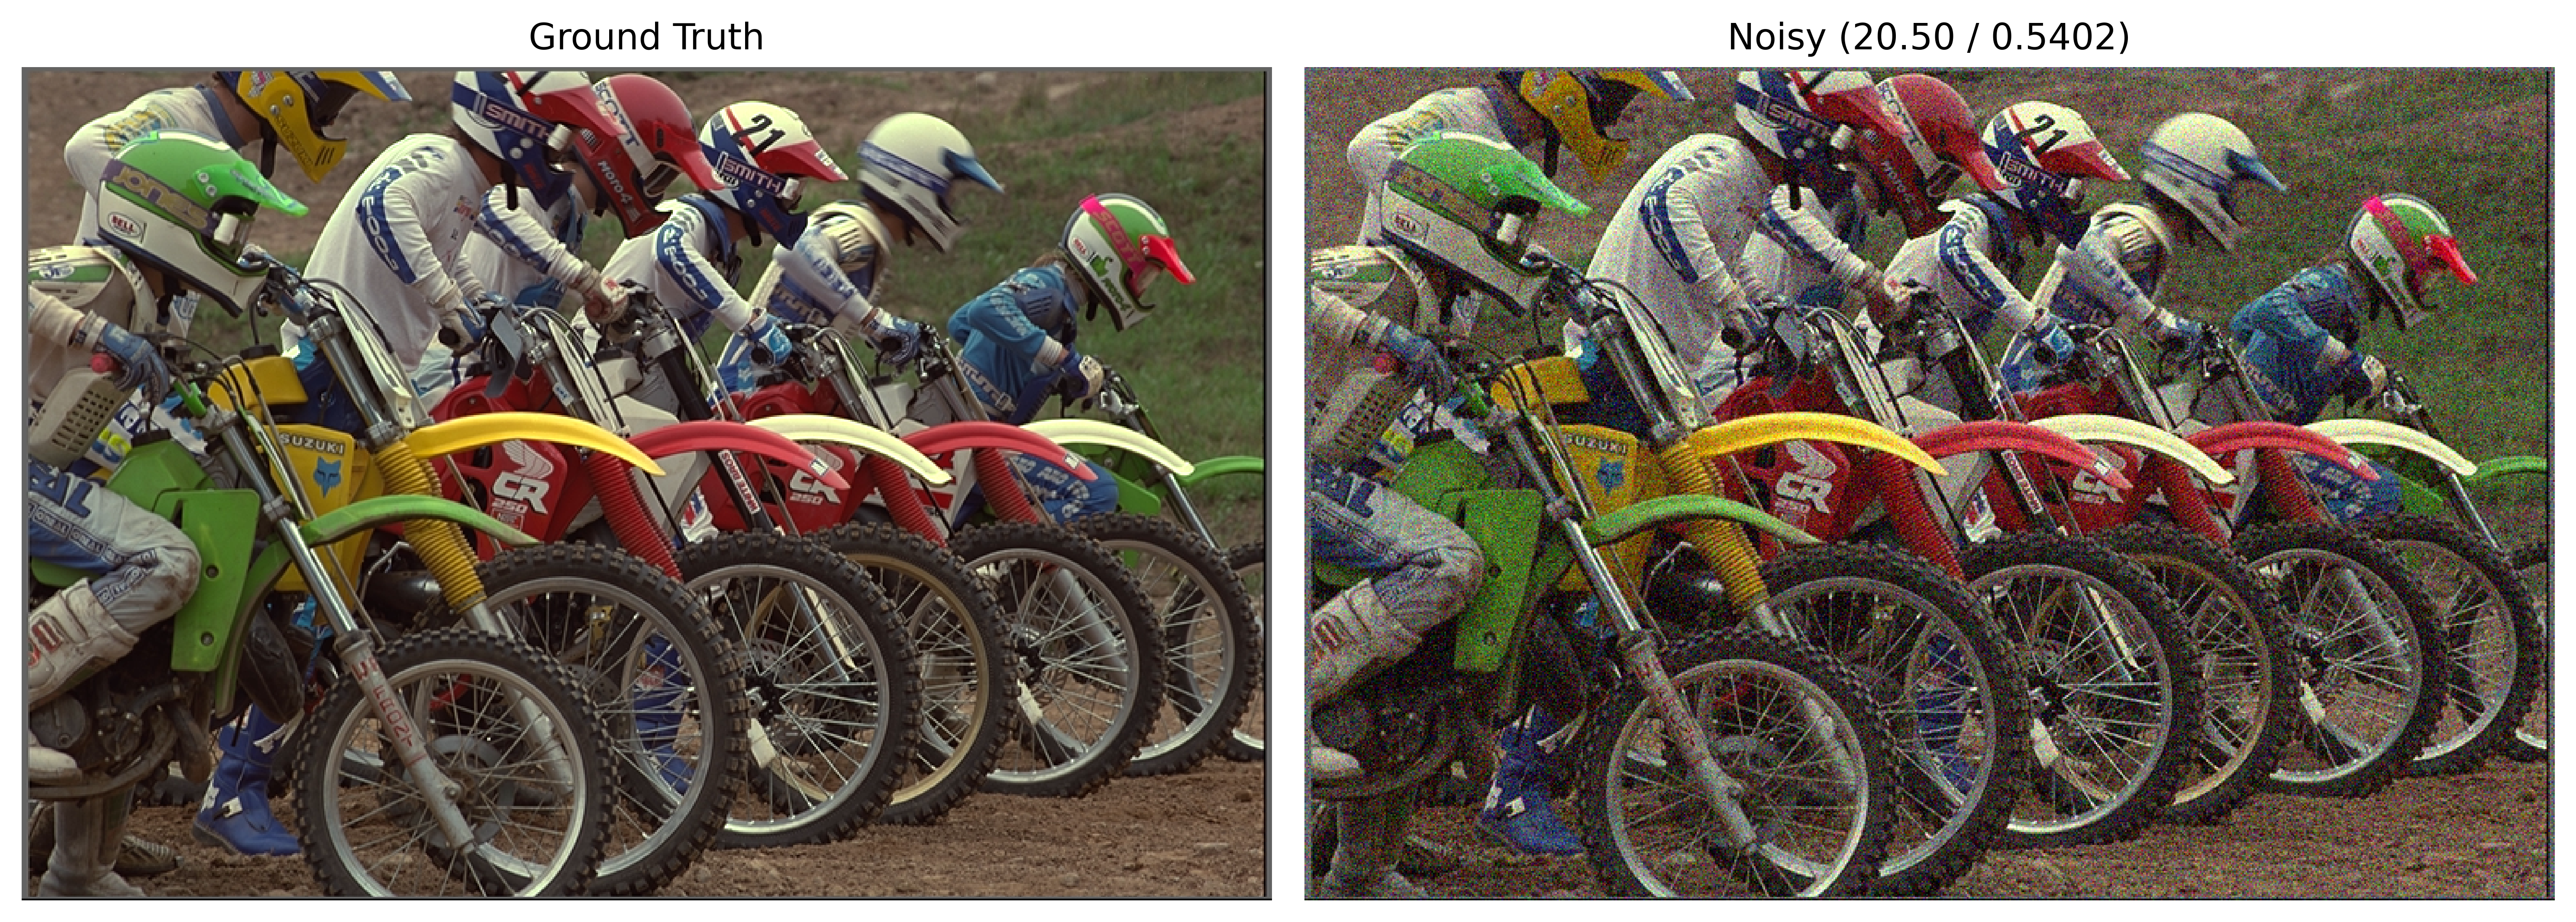

In [19]:
img1 = np.load(data_path)['gt'].transpose(1, 2, 0).clip(0, 1)
img2 = np.load(data_path)['noisy'].transpose(1, 2, 0).clip(0, 1)
compare_and_plot(img1, img2, 'Ground Truth', 'Noisy')

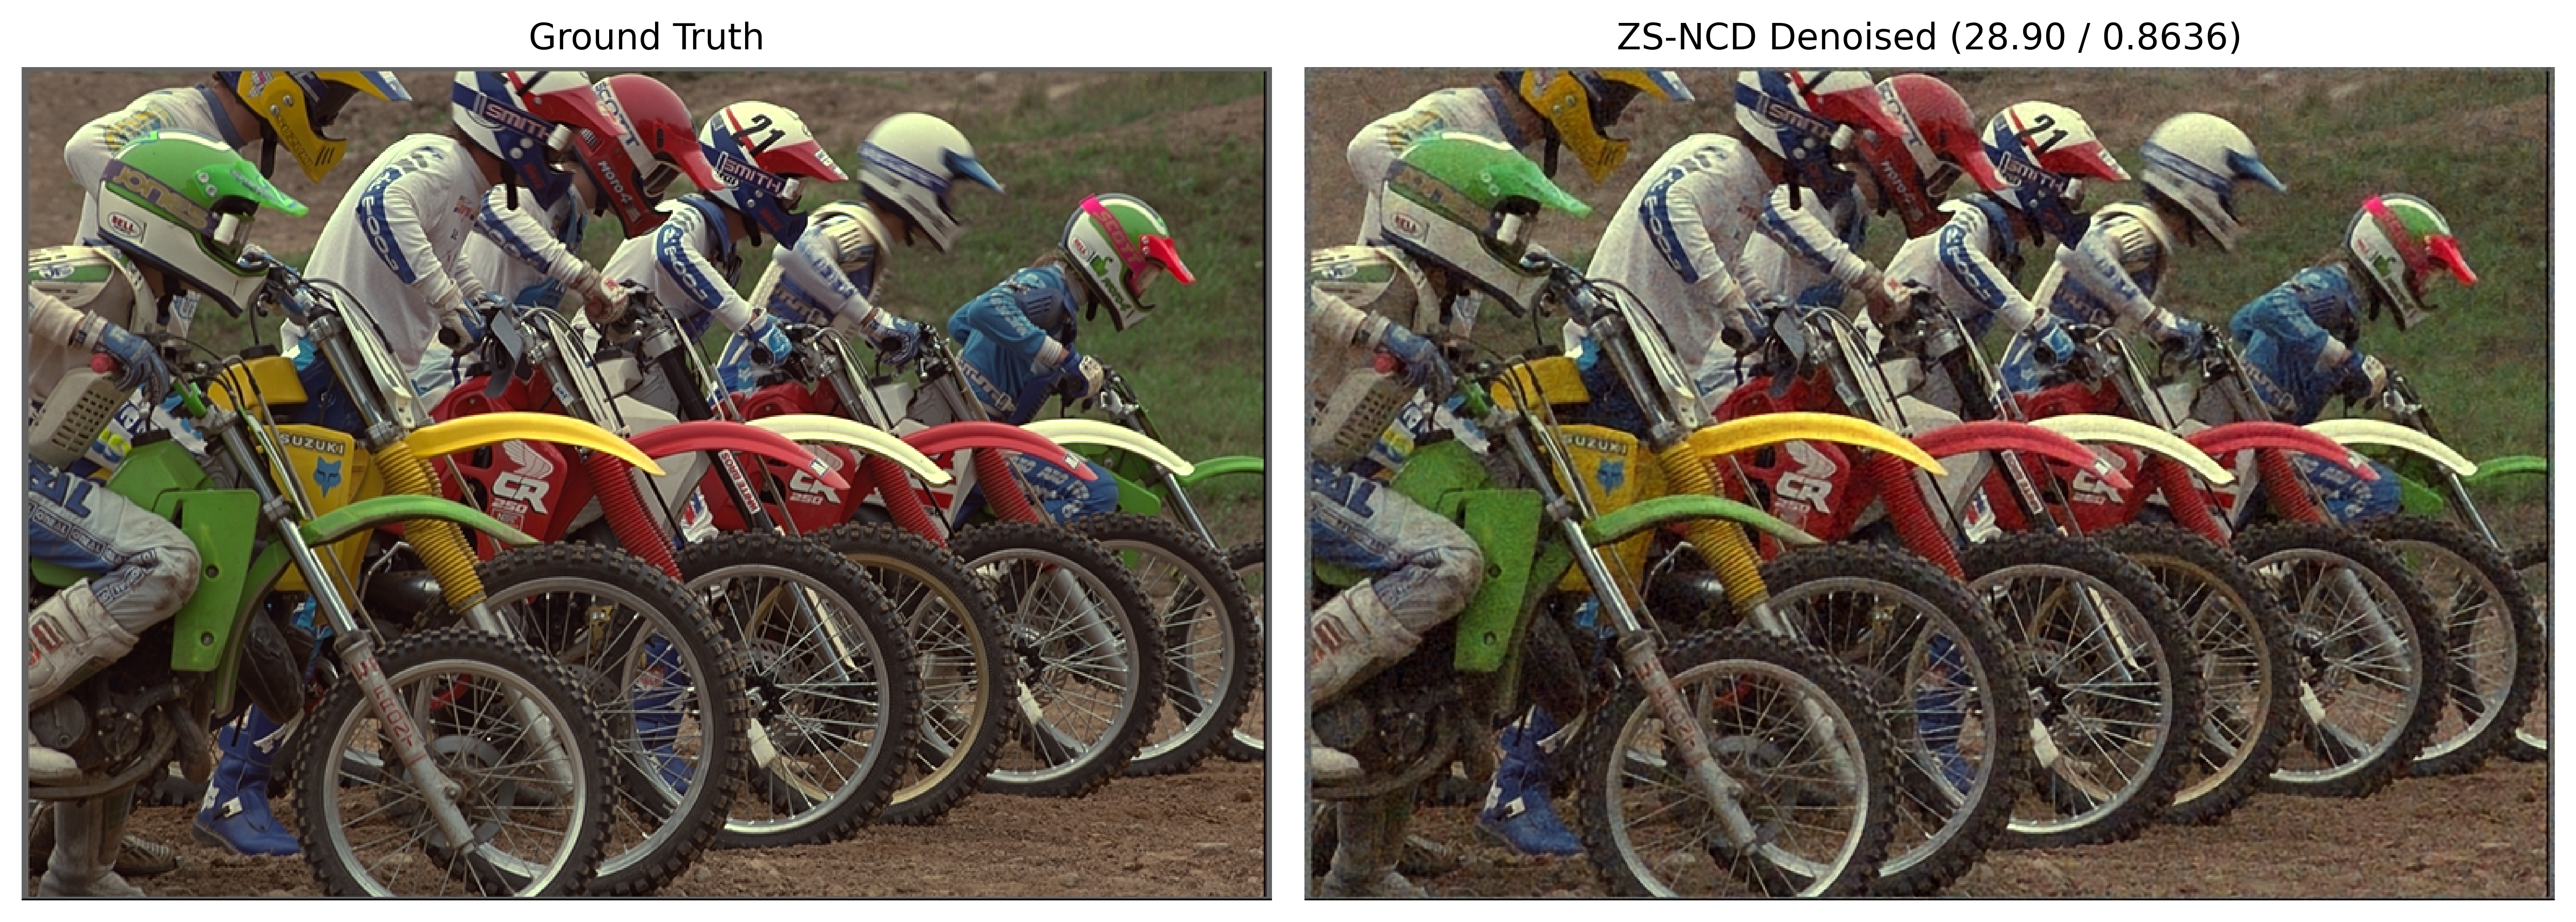

In [22]:
img1 = np.load(data_path)['gt'].transpose(1, 2, 0).clip(0, 1)
img2 = (np.array(Image.open(lastk_checkpoint.last_image_path)) / 255.0).clip(0, 1)
compare_and_plot(img1, img2, 'Ground Truth', 'ZS-NCD Denoised')